In [1]:
import numpy as np
import pickle
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [3]:
# Define the file paths
file_paths = ["index_history.pkl", "saved_indexes.pkl", "saved_symbols.pkl", "ticker_history.pkl"]

# Load the data from each file
data_dict = {}

for path in file_paths:
    with open(path, "rb") as file:
        data = pickle.load(file, encoding='latin1')
        data_dict[path] = data

# Access the loaded data
index_history = data_dict["index_history.pkl"]
saved_indices = data_dict["saved_indexes.pkl"]
saved_tickers = data_dict["saved_symbols.pkl"]
ticker_history = data_dict["ticker_history.pkl"]

# Print some information about the loaded data (optional)
print("Index History:", type(index_history), len(index_history))
print("Saved Indices:", type(saved_indices), len(saved_indices))
print("Saved Tickers:", type(saved_tickers), len(saved_tickers))
print("Ticker History:", type(ticker_history), len(ticker_history))

Index History: <class 'dict'> 20
Saved Indices: <class 'list'> 20
Saved Tickers: <class 'list'> 101
Ticker History: <class 'dict'> 101


In [29]:
#define the function that adds log_returns

def add_log_returns(df):
    opens = df['Open'].values
    df['log_returns'] = np.log10(opens/opens[0])
    df['date'] = df.index.date

In [30]:
for index in index_history:
    add_log_returns(index_history[index])

for ticker in ticker_history:
    add_log_returns(ticker_history[ticker])

In [31]:
for ticker in ticker_history:
    if ticker_history[ticker]['log_returns'][0] == np.nan:
        print(ticker)

for index in index_history:
    if index_history[index]['log_returns'][0] == np.nan:
        print(index)

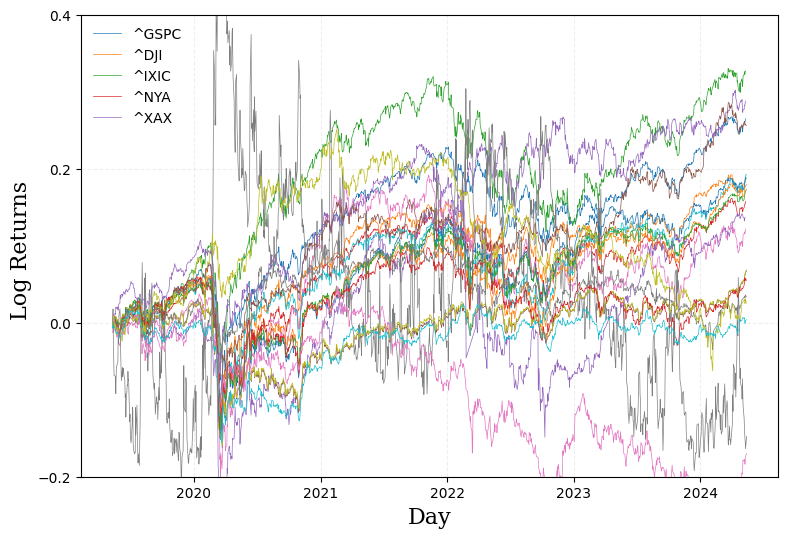

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

for i, index_name in enumerate(saved_indices):
    if i < 5:
        ax.plot(index_history[index_name]['log_returns'], lw=0.5, label=index_name)
    else:
        ax.plot(index_history[index_name]['log_returns'], lw=0.5)

ax.set_ylabel(r'Log Returns ', fontsize=16, fontfamily='serif')
ax.set_xlabel(r'Day', fontsize=16, fontfamily='serif')

ax.set_ylim([-0.2, 0.4])
ax.set_yticks(np.arange(-0.2, 0.6, 0.2))

ax.grid(ls='--', alpha=0.2)

ax.legend(frameon=False)

plt.savefig('index_history_log_returns.png', dpi=300, bbox_inches='tight')
